# Neural Machine Translation


* In this project we will build a Neural Machine Translation `NMT` model to translate human-readable dates (`25th of June, 2009`) into machine-readable dates (`2009-06-25`).
* You will do this using an `LSTM` model combined with  `attention`.


$$$$

## Packages

In [ ]:
!pip install faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.3 MB/s eta 0:00:00


In [ ]:
import random
from tqdm import tqdm
from babel.dates import format_date
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from faker import Faker
fake = Faker()
Faker.seed(12345)
random.seed(12345)


from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
import tensorflow as tf
tf.config.list_physical_devices()

$$$$

$$$$

## 1 - Dataset

In [ ]:
# Define format of the data we would like to generate
FORMATS = ['short','medium','long','full','full','full','full','full','full','full','full','full','full',
           'd MMM YYY','d MMMM YYY','dd MMM YYY','d MMM, YYY','d MMMM, YYY','dd, MMM YYY','d MM YY',
           'd MMMM YYY','MMMM d YYY','MMMM d, YYY','dd.MM.YY']

In [ ]:
def load_date():
    """
        Loads some fake dates
        :returns: tuple containing human readable string, machine readable string, and date object
    """
    dt = fake.date_object()

    try:
        human_readable = format_date(dt, format=random.choice(FORMATS),  locale='en_US') # locale=random.choice(LOCALES))
        human_readable = human_readable.lower()
        human_readable = human_readable.replace(',','')
        machine_readable = dt.isoformat()

    except AttributeError as e:
        return None, None, None

    return human_readable, machine_readable, dt

In [ ]:
h, m, _ = load_date()
print(h)
print(m)
print(tuple(h))

friday august 6 1999
1999-08-06
('f', 'r', 'i', 'd', 'a', 'y', ' ', 'a', 'u', 'g', 'u', 's', 't', ' ', '6', ' ', '1', '9', '9', '9')


In [ ]:
def load_dataset(m):
    """
        Loads a dataset with m examples and vocabularies
        :m: the number of examples to generate
    """

    human_vocab = set()
    machine_vocab = set()
    dataset = []
    Tx = 30


    for i in tqdm(range(m)):
        h, m, _ = load_date()
        if h is not None:
            dataset.append((h, m))
            human_vocab.update(tuple(h))
            machine_vocab.update(tuple(m))

    human = dict(zip(sorted(human_vocab) + ['<unk>', '<pad>'],
                     list(range(len(human_vocab) + 2))))
    inv_machine = dict(enumerate(sorted(machine_vocab)))
    machine = {v:k for k,v in inv_machine.items()}

    return dataset, human, machine, inv_machine


In [ ]:
m = 10000 # N° of human readable dates in the dataset
dataset, human_vocab, machine_vocab, inv_machine_vocab = load_dataset(m)

100%|██████████| 10000/10000 [00:00<00:00, 13095.81it/s]


In [ ]:
dataset[:10]

[('12 jul 1992', '1992-07-12'),
 ('20.07.70', '1970-07-20'),
 ('8/16/14', '2014-08-16'),
 ('monday february 24 1986', '1986-02-24'),
 ('sunday december 3 1989', '1989-12-03'),
 ('saturday june 21 1980', '1980-06-21'),
 ('thursday august 10 2000', '2000-08-10'),
 ('29 sep 1978', '1978-09-29'),
 ('20 sep 1976', '1976-09-20'),
 ('sunday may 30 1993', '1993-05-30')]

- `dataset`: a list of tuples of (human readable date, machine readable date).
- `human_vocab`: a python dictionary mapping all characters used in the human readable dates to an integer-valued index.
- `machine_vocab`: a python dictionary mapping all characters used in machine readable dates to an integer-valued index.
    - **Note**: These indices are not necessarily consistent with `human_vocab`.
- `inv_machine_vocab`: the inverse dictionary of `machine_vocab`, mapping from indices back to characters.



**Preprocess Data**

> Let's preprocess the data and map the raw text data into the index values.
- We will set `Tx=30`
    - We assume Tx is the maximum length of the human readable date.
    - If we get a longer input, we would have to truncate it.
- We will set `Ty=10`
    - "YYYY-MM-DD" is 10 characters long.

In [ ]:
def string_to_int(string, length, vocab):
    """
    Converts all strings in the vocabulary into a list of integers

    Arguments:
    string -- input string, e.g. 'Wed 10 Jul 2007'
    length -- the number of time steps you'd like, determines if the output will be padded or cut
    vocab -- vocabulary, dictionary used to index every character of your "string"

    Returns:
    rep -- list of integers (or '<unk>') (size = length) representing the position of the string's character in the vocabulary
    """

    #make lower to standardize
    string = string.lower()
    string = string.replace(',','')

    if len(string) > length:
        string = string[:length]

    rep = list(map(lambda x: vocab.get(x, '<unk>'), string))
    if len(string) < length:
        rep += [vocab['<pad>']] * (length - len(string))

    return rep

In [ ]:
def preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty):

    X, Y = zip(*dataset)

    X = np.array([string_to_int(i, Tx, human_vocab) for i in X])
    Y = [string_to_int(t, Ty, machine_vocab) for t in Y]

    Xoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), X)))
    Yoh = np.array(list(map(lambda x: to_categorical(x, num_classes=len(machine_vocab)), Y)))

    return X, np.array(Y), Xoh, Yoh

In [ ]:
Tx = 30
Ty = 10
X, Y, Xoh, Yoh = preprocess_data(dataset, human_vocab, machine_vocab, Tx, Ty)

print("X.shape:", X.shape)
print("Y.shape:", Y.shape)
print("Xoh.shape:", Xoh.shape)
print("Yoh.shape:", Yoh.shape)


X.shape: (10000, 30)
Y.shape: (10000, 10)
Xoh.shape: (10000, 30, 37)
Yoh.shape: (10000, 10, 11)


- `X`: a processed version of the human readable dates in the training set.
    - Each character in X is replaced by an index (integer) mapped to the character using `human_vocab`.
    - Each date is padded to ensure a length of `Τ_x` using a special character `< pad >`.
    - `X.shape = (m, Tx)` where m is the number of training examples in a batch.
- `Y`: a processed version of the machine readable dates in the training set.
    - Each character is replaced by the index, it is mapped to in `machine_vocab`.
    - `Y.shape = (m, Ty)`.
- `Xoh`: one-hot version of `X`
    - Each index in `X` is converted to the one-hot representation
    - `Xoh.shape = (m, Tx, len(human_vocab))`
- `Yoh`: one-hot version of `Y`
    - Each index in `Y` is converted to the one-hot representation.
    - `Yoh.shape = (m, Ty, len(machine_vocab))`.
    - `len(machine_vocab) = 11` since there are 10 numeric digits (0 to 9) and the `-` symbol.

> Let's also look at some examples of preprocessed training examples.


In [ ]:
index = np.random.choice(range(m))
print("Source date:", dataset[index][0])
print("Target date:", dataset[index][1])
print()
print("Source after preprocessing (indices):\n", X[index])
print("Target after preprocessing (indices):\n", Y[index])
print()
print("Source after preprocessing (one-hot):\n", Xoh[index])
print("Target after preprocessing (one-hot):\n", Yoh[index])

Source date: march 15 1974
Target date: 1974-03-15

Source after preprocessing (indices):
 [24 13 28 15 20  0  4  8  0  4 12 10  7 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36]
Target after preprocessing (indices):
 [ 2 10  8  5  0  1  4  0  2  6]

Source after preprocessing (one-hot):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
Target after preprocessing (one-hot):
 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


$$$$

## 2 - Neural Machine Translation with Attention




* The network will input a date written in a variety of possible formats (*e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987"*)
* The network will translate them into standardized, machine readable dates (*e.g. "1958-08-29", "1968-03-30", "1987-06-24"*).
* We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD.


In [ ]:
def softmax(x, axis=1):
    """Softmax activation function.
    # Arguments
        x : Tensor.
        axis: Integer, axis along which the softmax normalization is applied.
    # Returns
        Tensor, output of softmax transformation.
    # Raises
        ValueError: In case `dim(x) == 1`.
    """
    ndim = K.ndim(x)
    if ndim == 2:
        return K.softmax(x)
    elif ndim > 2:
        e = K.exp(x - K.max(x, axis=axis, keepdims=True))
        s = K.sum(e, axis=axis, keepdims=True)
        return e / s
    else:
        raise ValueError('Cannot apply softmax to a tensor that is 1D')

### 2.1- Attention Mechanism


In [ ]:
# Defined shared layers as global variables
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Activation(softmax, name='attention_weights')
dotor = Dot(axes = 1)

In [ ]:
# One Step Attention
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """
    s_prev = repeator(s_prev)
    # concatenate a and s_prev on the last axis
    concat = concatenator([a,s_prev])
    e = densor1(concat)
    energies = densor2(e)
    alphas = activator(energies)
    context = dotor([alphas,a])
    return context

In [ ]:
n_a = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s, return_state = True)
output_layer = Dense(len(machine_vocab), activation=softmax)

In [ ]:
def modelf(Tx, Ty, n_a, n_s, human_vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_a -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    human_vocab_size -- size of the python dictionary "human_vocab"
    machine_vocab_size -- size of the python dictionary "machine_vocab"

    Returns:
    model -- Keras model instance
    """

    X = Input(shape=(Tx, human_vocab_size)) # input of the model with a shape (Tx,)
    s0 = Input(shape=(n_s,), name='s0') # (initial hidden state)
    c0 = Input(shape=(n_s,), name='c0') # (initial cell state)
    s = s0
    c = c0

    # Initialize empty list of outputs
    outputs = []

    # pre-attention Bi-LSTM. (Encoder)
    a = Bidirectional(LSTM(n_a, return_sequences=True))(X)

    # Step 2: Iterate for Ty steps
    for t in range(Ty):

        # one step attention mechanism to get back the context vector at step t
        context = one_step_attention(a, s)

        # post-attention LSTM cell to the "context" vector.
        s, _, c = post_activation_LSTM_cell(context,initial_state=[s, c])

        # Dense layer to the hidden state output of the post-attention LSTM
        out = output_layer(s)

        outputs.append(out)

    model = Model(inputs=[X, s0, c0],outputs=outputs)

    return model

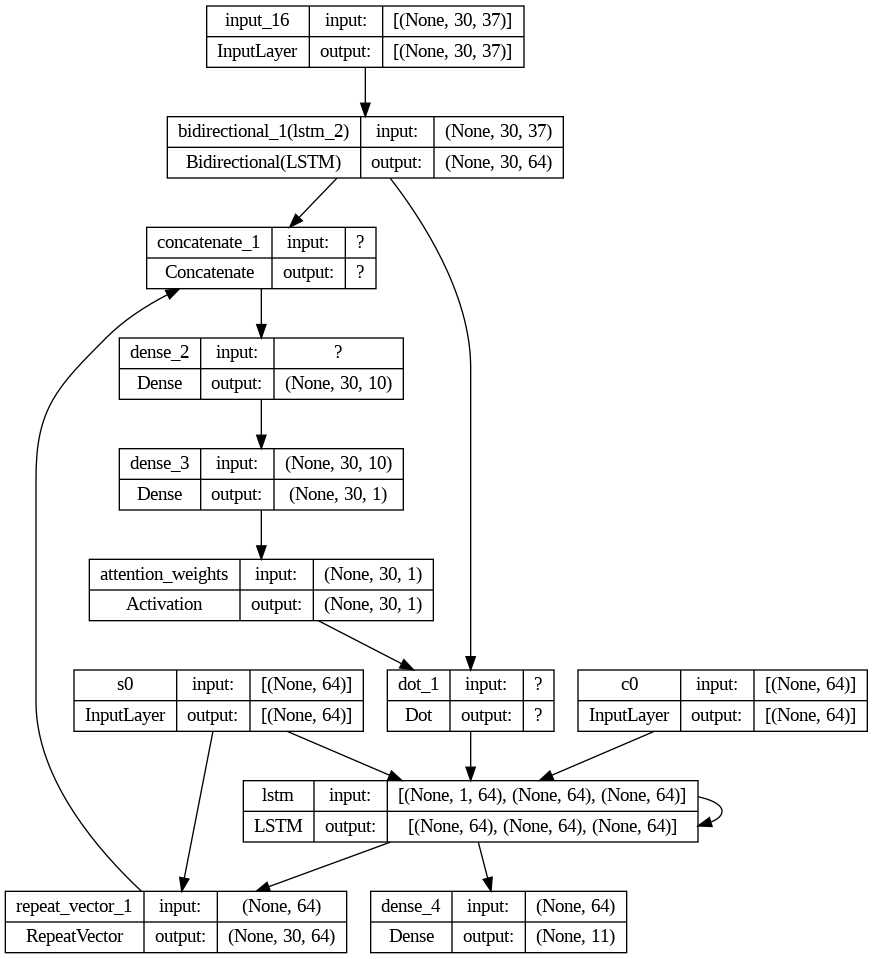

In [ ]:
model = modelf(Tx, Ty, n_a, n_s, len(human_vocab), len(machine_vocab))
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Define inputs and outputs, and fit the model
The last step is to define all your inputs and outputs to fit the model:
- The input X of shape $(m = 10000, T_x = 30)$ containing the training examples.
- We need to create `s0` and `c0` to initialize the `post_attention_LSTM_cell` with zeros.
- Given the `model()`, we need the "outputs" to be a list of 10 elements of shape (m, T_y).
    - The list `outputs[i][0], ..., outputs[i][Ty]` represents the true labels (characters) corresponding to the $i^{th}$ training example (`X[i]`).
    - `outputs[i][j]` is the true label of the $j^{th}$ character in the $i^{th}$ training example.

In [ ]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Yoh.swapaxes(0,1))

Let's now fit the model and run it for one epoch.

In [ ]:
history = model.fit([Xoh, s0, c0], outputs, epochs=10, batch_size=100)

100/100 [==============================] - 32s 91ms/step - loss: 2.6740 - dense_4_loss: 0.0652 - dense_4_1_loss: 0.0706 - dense_4_2_loss: 0.4195 - dense_4_3_loss: 0.5387 - dense_4_4_loss: 0.1209 - dense_4_5_loss: 0.0897 - dense_4_6_loss: 0.4091 - dense_4_7_loss: 0.1395 - dense_4_8_loss: 0.3879 - dense_4_9_loss: 0.4329 - dense_4_accuracy: 0.9808 - dense_4_1_accuracy: 0.9782 - dense_4_2_accuracy: 0.8777 - dense_4_3_accuracy: 0.8670 - dense_4_4_accuracy: 0.9877 - dense_4_5_accuracy: 0.9702 - dense_4_6_accuracy: 0.9289 - dense_4_7_accuracy: 0.9856 - dense_4_8_accuracy: 0.8933 - dense_4_9_accuracy: 0.9268



> `dense_4_acc_8: 0.89` means that you are predicting the 7th character of the output correctly 89% of the time in the current batch of data.


$$$$

## Model Predictions

In [ ]:
EXAMPLES = ['3 May 1979', '5 April 09', '21th of August 2016', 'Tue 10 Jul 2007', 'Saturday May 9 2018', 'March 3 2001', 'March 3rd 2001', '1 March 2001']
s00 = np.zeros((1, n_s))
c00 = np.zeros((1, n_s))
for example in EXAMPLES:
    source = string_to_int(example, Tx, human_vocab)
    # print(source)
    source = np.array(list(map(lambda x: to_categorical(x, num_classes=len(human_vocab)), source))).swapaxes(0,1)
    source = np.swapaxes(source, 0, 1)
    source = np.expand_dims(source, axis=0)
    prediction = model.predict([source, s00, c00])
    prediction = np.argmax(prediction, axis = -1)
    output = [inv_machine_vocab[int(i)] for i in prediction]
    print("source:", example)
    print("output:", ''.join(output),"\n")

1/1 [==============================] - 0s 44ms/step
source: 3 May 1979
output: 1979-05-03 

1/1 [==============================] - 0s 43ms/step
source: 5 April 09
output: 2009-04-05 

1/1 [==============================] - 0s 27ms/step
source: 21th of August 2016
output: 2016-08-21 

1/1 [==============================] - 0s 30ms/step
source: Tue 10 Jul 2007
output: 2007-07-10 

1/1 [==============================] - 0s 30ms/step
source: Saturday May 9 2018
output: 2018-05-09 

1/1 [==============================] - 0s 30ms/step
source: March 3 2001
output: 2001-03-03 

1/1 [==============================] - 0s 28ms/step
source: March 3rd 2001
output: 2001-03-03 

1/1 [==============================] - 0s 28ms/step
source: 1 March 2001
output: 2001-03-01 



$$$$

## Translate & Plot Attention Weights

In [ ]:
def int_to_string(ints, inv_vocab):
    """
    Output a machine readable list of characters based on a list of indexes in the machine's vocabulary
    """
    l = [inv_vocab[i] for i in ints]
    return l

In [ ]:
def plot_attention_map(modelx, input_vocabulary, inv_output_vocabulary, text, n_s = 128, num = 7):
    """
    Plot the attention map.

    """
    attention_map = np.zeros((10, 30))
    layer = modelx.get_layer('attention_weights')

    Ty, Tx = attention_map.shape

    human_vocab_size = 37

    X = modelx.inputs[0]
    s0 = modelx.inputs[1]
    c0 = modelx.inputs[2]
    s = s0
    c = s0

    a = modelx.layers[2](X)
    outputs = []

    for t in range(Ty):
        s_prev = s
        s_prev = modelx.layers[3](s_prev)
        concat = modelx.layers[4]([a, s_prev])
        e = modelx.layers[5](concat)
        energies = modelx.layers[6](e)
        alphas = modelx.layers[7](energies)
        context = modelx.layers[8]([alphas, a])
        # Don't forget to pass: initial_state = [hidden state, cell state] (≈ 1 line)
        s, _, c = modelx.layers[10](context, initial_state = [s, c])
        outputs.append(energies)

    f = Model(inputs=[X, s0, c0], outputs = outputs)


    s0 = np.zeros((1, n_s))
    c0 = np.zeros((1, n_s))
    encoded = np.array(string_to_int(text, Tx, input_vocabulary)).reshape((1, 30))
    encoded = np.array(list(map(lambda x: to_categorical(x, num_classes=len(input_vocabulary)), encoded)))


    r = f([encoded, s0, c0])

    for t in range(Ty):
        for t_prime in range(Tx):
            attention_map[t][t_prime] = r[t][0, t_prime]

    # Normalize attention map
    row_max = attention_map.max(axis=1)
    attention_map = attention_map / row_max[:, None]

    prediction = modelx.predict([encoded, s0, c0])

    predicted_text = []
    for i in range(len(prediction)):
        predicted_text.append(int(np.argmax(prediction[i], axis=1)))

    predicted_text = list(predicted_text)
    predicted_text = int_to_string(predicted_text, inv_output_vocabulary)
    text_ = list(text)

    # get the lengths of the string
    input_length = len(text)
    output_length = Ty

    # Plot the attention_map
    plt.clf()
    f = plt.figure(figsize=(8, 8.5))
    ax = f.add_subplot(1, 1, 1)

    # add image
    i = ax.imshow(attention_map, interpolation='nearest', cmap='Blues')

    # add colorbar
    cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
    cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
    cbar.ax.set_xlabel('Alpha value (Probability output of the "softmax")', labelpad=2)

    # add labels
    ax.set_yticks(range(output_length))
    ax.set_yticklabels(predicted_text[:output_length])

    ax.set_xticks(range(input_length))
    ax.set_xticklabels(text_[:input_length], rotation=45)

    ax.set_xlabel('Input Sequence')
    ax.set_ylabel('Output Sequence')

    # add grid and legend
    ax.grid()

    #f.show()

    return attention_map

1/1 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

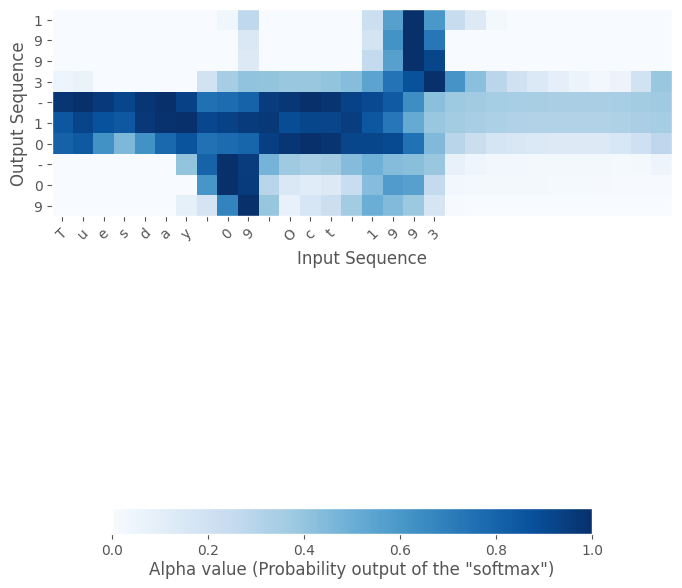

In [ ]:
example_date = "Tuesday 09 Oct 1993"
attention_map = plot_attention_map(model, human_vocab, inv_machine_vocab, example_date, num = 7, n_s = 64);